本笔记本为[教材](http://manipulation.csail.mit.edu/intro.html)配套示例。建议将本页面与教材网页并排打开！

## 在 Deepnote 上运行本笔记本的说明

- 登录（本课程使用免费账号即可）
- 点击右上角 Login 旁的“Duplicate”图标复制文档
- 逐个阅读/运行代码单元，或点击本单元上方的“Run notebook”图标一键运行
- 启动可视化工具后，在本笔记本第二个代码单元下方会打印一个网址，点击即可打开可视化界面
- 远程操作时，可使用第三/第四个代码单元输出的键盘指令，或在 meshcat 界面点击“Open controls”并使用滑块
- 结束时，按 ESC 键或点击 meshcat 中的“Stop Simulation”按钮即可

In [3]:
import numpy as np
from pydrake.geometry import StartMeshcat
from pydrake.multibody.inverse_kinematics import (
    DifferentialInverseKinematicsParameters,
    DifferentialInverseKinematicsStatus,
    DoDifferentialInverseKinematics,
    )
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, EventStatus, LeafSystem
from pydrake.visualization import MeshcatPoseSliders
from pydrake.systems.drawing import plot_system_graphviz

from manipulation import running_as_notebook  # 判断当前代码是否在 Jupyter Notebook 环境下运行。用于区分交互式仿真和脚本/测试环境
from manipulation.meshcat_utils import StopButton, WsgButton  # 用于在 Meshcat 中添加停止按钮和夹爪控制按钮
from manipulation.station import LoadScenario, MakeHardwareStation, MakeMultibodyPlant  # 用于加载场景和创建多体植物
from manipulation.systems import AddIiwaDifferentialIK, MultibodyPositionToBodyPose  # 用于添加 iiwa 差分逆运动学和将多体位置转换为刚体位姿

In [4]:
# 启动可视化工具。
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# 远程操作示例（2D）

在本例中，我们将组装一个包含所有相关子系统的图（manipulation station、meshcat 可视化器、用于最小远程操作界面的系统，以及将末端执行器命令转换为关节命令的系统）。后续章节会详细介绍这些组件。

**注意：** 如果你让机器人夹爪移动到不可达的位置，会出现“differential IK”失败的提示。这里没有设置很保守的滑块限制，部分原因是这样有教学意义。后面我们会更精确地理解它！现在如果卡住了，只需停止仿真并重新运行该单元即可。

In [3]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://manipulation/planar_iiwa14_no_collision.urdf
    default_joint_positions:
        iiwa_joint_2: [0.1]
        iiwa_joint_4: [-1.2]
        iiwa_joint_6: [1.6]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
- add_model:
    name: robot_table
    file: package://manipulation/hydro/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: robot_table::link
    X_PC:
        translation: [0, 0, -0.7645]
- add_model:
    name: work_table
    file: package://manipulation/hydro/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: work_table::link
    X_PC:
        translation: [0.75, 0, -0.7645]
# Restrict the brick to move only in the x-z plane
- add_model:
    name: planar_joint
    file: package://manipulation/planar_joint.sdf
    default_joint_positions:
        planar_joint: [0.6, 0, 0]
- add_weld:
    parent: world
    child: planar_joint::parent
    X_PC:
        rotation: !Rpy { deg: [90, 0, 0]}
- add_weld:
    parent: planar_joint::child
    child: foam_brick::base_link
model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      desired_kp_gains: [500, 500, 200]
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""


def teleop_2d():
    scenario = LoadScenario(data=scenario_data)
    meshcat.Set2dRenderMode(xmin=-0.25, xmax=1.5, ymin=-0.1, ymax=1.3)

    builder = DiagramBuilder()

    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))

    # Set up differential inverse kinematics.
    diff_ik_plant = MakeMultibodyPlant(scenario, model_instance_names=["iiwa"])
    differential_ik = AddIiwaDifferentialIK(builder, diff_ik_plant)
    builder.Connect(
        differential_ik.get_output_port(),
        station.GetInputPort("iiwa.position"),
    )
    builder.Connect(
        station.GetOutputPort("iiwa.state_estimated"),
        differential_ik.GetInputPort("robot_state"),
    )

    # Set up teleop widgets.
    meshcat.DeleteAddedControls()
    teleop = builder.AddSystem(
        MeshcatPoseSliders(
            meshcat,
            lower_limit=[0, -np.pi, -np.pi, -0.6, -1, 0],
            upper_limit=[2 * np.pi, np.pi, np.pi, 0.8, 1, 1.1],
            # Only roll, x, and z are used in this example:
            visible=[True, False, False, True, False, True],
            decrement_keycodes=["KeyQ", "", "", "ArrowLeft", "", "ArrowDown"],
            increment_keycodes=["KeyE", "", "", "ArrowRight", "", "ArrowUp"],
        )
    )
    builder.Connect(
        teleop.get_output_port(), differential_ik.GetInputPort("X_WE_desired")
    )
    ee_pose = builder.AddSystem(
        MultibodyPositionToBodyPose(
            diff_ik_plant, diff_ik_plant.GetBodyByName("iiwa_link_7")
        )
    )
    builder.Connect(
        station.GetOutputPort("iiwa.position_measured"), ee_pose.get_input_port()
    )
    builder.Connect(ee_pose.get_output_port(), teleop.get_input_port())
    wsg_teleop = builder.AddSystem(WsgButton(meshcat))
    builder.Connect(wsg_teleop.get_output_port(0), station.GetInputPort("wsg.position"))
    builder.AddSystem(StopButton(meshcat))

    # Simulate.
    diagram = builder.Build()
    simulator = Simulator(diagram)

    if running_as_notebook:  # Then we're not just running as a test on CI.
        simulator.set_target_realtime_rate(1.0)
        simulator.AdvanceTo(np.inf)
    else:
        simulator.set_target_realtime_rate(0)
        simulator.AdvanceTo(0.1)


teleop_2d()

INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/7b92aacbe021861ec9bbbb82d8ab9a19ded970ff.tar.gz
Press Space to open/close the gripper
Press Escape to stop the simulation


KeyboardInterrupt: 

# 远程操作示例（3D）

上面仿真的物理和几何引擎实际上运行在三维空间。本例几乎完全相同，但我们将使用（默认的）三维可视化，并增加更多滑块以控制末端执行器的完整 `roll`、`pitch`、`yaw` 角和 `x`、`y`、`z` 位置。

Press Space to open/close the gripper


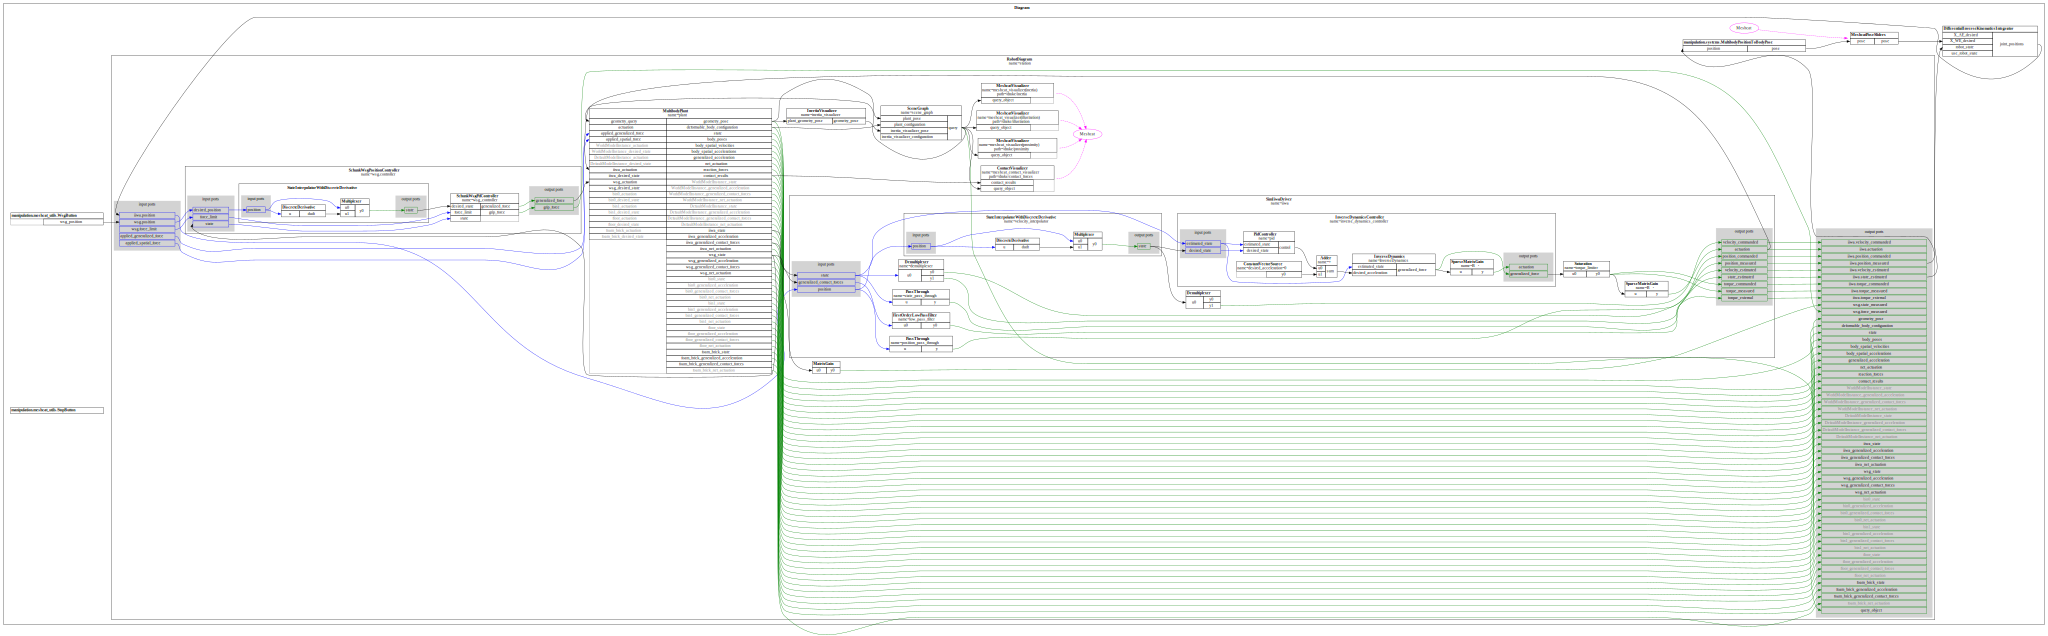

Press Escape to stop the simulation


In [ ]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0, -0.6, 0.2]
model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""


def teleop_3d():
    meshcat.ResetRenderMode()

    builder = DiagramBuilder()

    scenario = LoadScenario(data=scenario_data)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))

    # Set up differential inverse kinematics.
    diff_ik_plant = MakeMultibodyPlant(scenario, model_instance_names=["iiwa"])
    differential_ik = AddIiwaDifferentialIK(builder, diff_ik_plant)
    builder.Connect(
        differential_ik.get_output_port(),
        station.GetInputPort("iiwa.position"),
    )
    builder.Connect(
        station.GetOutputPort("iiwa.state_estimated"),
        differential_ik.GetInputPort("robot_state"),
    )

    # Set up teleop widgets.
    meshcat.DeleteAddedControls()
    teleop = builder.AddSystem(
        MeshcatPoseSliders(
            meshcat,
            lower_limit=[0, -0.5, -np.pi, -0.6, -0.8, 0.0],
            upper_limit=[2 * np.pi, np.pi, np.pi, 0.8, 0.3, 1.1],
        )
    )
    builder.Connect(
        teleop.get_output_port(), differential_ik.GetInputPort("X_WE_desired")
    )
    ee_pose = builder.AddSystem(
        MultibodyPositionToBodyPose(
            diff_ik_plant, diff_ik_plant.GetBodyByName("iiwa_link_7")
        )
    )
    builder.Connect(
        station.GetOutputPort("iiwa.position_measured"), ee_pose.get_input_port()
    )
    builder.Connect(ee_pose.get_output_port(), teleop.get_input_port())
    wsg_teleop = builder.AddSystem(WsgButton(meshcat))
    builder.Connect(wsg_teleop.get_output_port(0), station.GetInputPort("wsg.position"))
    builder.AddSystem(StopButton(meshcat))

    diagram = builder.Build()
    plot_system_graphviz(diagram)
    simulator = Simulator(diagram)
    simulator.get_mutable_context()

    if running_as_notebook:  # Then we're not just running as a test on CI.
        simulator.set_target_realtime_rate(1.0)
        simulator.AdvanceTo(np.inf)
    else:
        simulator.set_target_realtime_rate(0)
        simulator.AdvanceTo(0.1)


teleop_3d()

# 使用手柄进行远程操作

如果你的电脑连接了[游戏手柄](https://gamepad-tester.com/)，只需在 meshcat 窗口聚焦时按下任意按钮，即可激活手柄支持。下面是带有手柄界面的演示。

```
末端执行器控制
-----------------------------------------
+/- x 轴         - 左摇杆 左/右
+/- y 轴         - 左摇杆 上/下
+/- roll         - 右摇杆 上/下
+/- pitch        - 右摇杆 左/右
+/- z 轴         - l2 / r2
+/- yaw           - l1 / r1

夹爪控制
-----------------------------------------
开/关           - 方块键 / 圆圈键 (O)

-----------------------------------------
x 键             - 退出
```

In [ ]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0, -0.6, 0.2]
model_drivers:
    iiwa: !IiwaDriver
      control_mode: position_only
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""


# TODO(russt): Clean this up and move it to a .py file.
class GamepadDiffIK(LeafSystem):
    def __init__(self, meshcat, plant, frame_E):
        """
        Args:
            meshcat: A Meshcat instance.
            plant: A multibody plant (to use for differential ik). It is
              probably the plant used for control, not for simulation (it should only contain the robot, not the objects).
            frame: A frame in to control `plant`.
        """
        LeafSystem.__init__(self)

        self.DeclareVectorInputPort("robot_state", plant.num_multibody_states())
        self.DeclareInitializationDiscreteUpdateEvent(self.Initialize)

        port = self.DeclareVectorOutputPort(
            "iiwa.position", plant.num_positions(), self.OutputIiwaPosition
        )
        # The gamepad has undeclared state.  For now, we accept it,
        # and simply disable caching on the output port.
        port.disable_caching_by_default()

        port = self.DeclareVectorOutputPort("wsg.position", 1, self.OutputWsgPosition)

        self.DeclareDiscreteState(plant.num_positions())  # iiwa position
        self.DeclareDiscreteState(1)  # wsg position
        self.DeclareDiscreteState(1)  # gripper button pressed
        self._time_step = 0.05
        self.DeclarePeriodicDiscreteUpdateEvent(self._time_step, 0, self.Integrate)

        self._meshcat = meshcat
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()

        if frame_E is None:
            frame_E = plant.GetFrameByName("body")  # wsg gripper frame
        self._frame_E = frame_E

        params = DifferentialInverseKinematicsParameters(
            plant.num_positions(), plant.num_velocities()
        )
        q0 = plant.GetPositions(plant.CreateDefaultContext())
        params.set_time_step(self._time_step)
        params.set_nominal_joint_position(q0)
        params.set_end_effector_angular_speed_limit(2)
        params.set_end_effector_translational_velocity_limits([-2, -2, -2], [2, 2, 2])
        iiwa14_velocity_limits = np.array([1.4, 1.4, 1.7, 1.3, 2.2, 2.3, 2.3])
        params.set_joint_velocity_limits(
            (-iiwa14_velocity_limits, iiwa14_velocity_limits)
        )
        params.set_joint_centering_gain(10 * np.eye(7))

        self._diff_ik_params = params
        self._wsg_open = 0.107
        self._wsg_close = 0.002

    def Initialize(self, context, discrete_state):
        discrete_state.set_value(
            0,
            self.get_input_port().Eval(context)[: self._plant.num_positions()],
        )
        discrete_state.set_value(1, [self._wsg_open])
        discrete_state.set_value(2, [0])

    def Integrate(self, context, discrete_state):
        gamepad = self._meshcat.GetGamepad()

        # https://beej.us/blog/data/javascript-gamepad/
        def CreateStickDeadzone(x, y):
            stick = np.array([x, y])
            deadzone = 0.3
            m = np.linalg.norm(stick)
            if m < deadzone:
                return np.array([0, 0])
            over = (m - deadzone) / (1 - deadzone)
            return stick * over / m

        left = CreateStickDeadzone(gamepad.axes[0], gamepad.axes[1])
        right = CreateStickDeadzone(gamepad.axes[2], gamepad.axes[3])

        V_WE_desired = np.zeros((6,))
        # TODO(russt): Properly implement rpydot to angular velocity.
        V_WE_desired[0] = -0.2 * right[0]  # Right stick x => wx
        V_WE_desired[1] = 0.2 * right[0]  # Right stick y => wy
        if gamepad.button_values[4] > 0.2 or gamepad.button_values[5] > 0.2:
            # l1/r1 => wz
            V_WE_desired[2] = 0.2 * (
                gamepad.button_values[5] - gamepad.button_values[4]
            )
        V_WE_desired[3] = -0.2 * left[0]  # Left stick x => vx
        V_WE_desired[4] = 0.2 * left[1]  # Left stick y => vy
        if gamepad.button_values[6] > 0.2 or gamepad.button_values[7] > 0.2:
            # l2/r2 => vx
            V_WE_desired[5] = 0.2 * (
                gamepad.button_values[7] - gamepad.button_values[6]
            )

        q = np.copy(context.get_discrete_state(0).get_value())
        self._plant.SetPositions(self._plant_context, q)
        result = DoDifferentialInverseKinematics(
            self._plant,
            self._plant_context,
            V_WE_desired,
            self._frame_E,
            self._diff_ik_params,
        )
        if result.status != DifferentialInverseKinematicsStatus.kNoSolutionFound:
            discrete_state.set_value(0, q + self._time_step * result.joint_velocities)

        # Toggle gripper open/close based on buttons
        x_pressed = context.get_discrete_state(2).get_value()[0]
        if gamepad.button_values[1] > 0.5:
            if not x_pressed:
                wsg_position = context.get_discrete_state(1).get_value()[0]
                if wsg_position == self._wsg_open:
                    discrete_state.set_value(1, [self._wsg_close])
                else:
                    discrete_state.set_value(1, [self._wsg_open])
            discrete_state.set_value(2, [1])
        else:
            discrete_state.set_value(2, [0])

        # TODO(russt): This doesn't actually work yet, since the event status
        # is being discarded in the pybind later.
        if gamepad.button_values[0] > 0.5:
            return EventStatus.ReachedTermination(self, "x button pressed")

        return EventStatus.Succeeded()

    def OutputIiwaPosition(self, context, output):
        output.set_value(context.get_discrete_state(0).get_value())

    def OutputWsgPosition(self, context, output):
        output.set_value(context.get_discrete_state(1).get_value())


def gamepad_teleop():
    if meshcat.GetGamepad().index == None:
        print(
            "Press a button on the gamepad with the meshcat window in focus to activate gamepad support (then run this cell again)."
        )
        return

    builder = DiagramBuilder()

    scenario = LoadScenario(data=scenario_data)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))
    meshcat.ResetRenderMode()
    meshcat.DeleteAddedControls()

    diff_ik_plant = MakeMultibodyPlant(scenario, model_instance_names=["iiwa"])
    frame = diff_ik_plant.GetFrameByName("iiwa_link_7")
    gamepad = builder.AddSystem(GamepadDiffIK(meshcat, diff_ik_plant, frame))
    builder.Connect(
        gamepad.GetOutputPort("iiwa.position"),
        station.GetInputPort("iiwa.position"),
    )
    builder.Connect(
        gamepad.GetOutputPort("wsg.position"),
        station.GetInputPort("wsg.position"),
    )
    builder.Connect(
        station.GetOutputPort("iiwa.state_estimated"),
        gamepad.GetInputPort("robot_state"),
    )
    builder.AddSystem(StopButton(meshcat))

    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.get_mutable_context()

    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(np.inf)


gamepad_teleop()